In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from datetime import datetime
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop



### Importing the data

In [159]:
user_cols = ['UserID','MovieID','Rating','Timestamp']
filename="./ratings.dat"
user_rating = pd.read_csv(filename, sep='::',names=user_cols, encoding='latin-1')
# user_rating.head()

item_cols = ['MovieID','Title','Genres']
filename="./movies.dat"
movies = pd.read_csv(filename, sep='::',names=item_cols, encoding='latin-1')
# movies.head()

final = user_rating.merge(movies, how='left', left_on='MovieID', right_on='MovieID')

#converting timestamp to date time 
final['Date']=final['Timestamp'].map(datetime.fromtimestamp).dt.date


# downsampling
# final=final.sample(frac=0.1)

## Save and load the data for time saving

In [132]:
# final.shape
# final.to_pickle('./final.pkl')
final=pd.read_pickle('./final.pkl')
final=final.iloc[0:100,:]

final.shape

(100, 7)

### Exploratory data analysis 

In [171]:
final.describe(include='all')
final.dtypes
final.isnull().sum()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Date
count,9.996588e+06,9.996588e+06,9.996588e+06,9.996588e+06,9996588,9996588,9996588
unique,NaN,NaN,NaN,NaN,10671,797,4638
top,NaN,NaN,NaN,NaN,Pulp Fiction (1994),Drama,2000-11-20
freq,NaN,NaN,NaN,NaN,34864,815081,64114
mean,3.586991e+04,4.115499e+03,3.512372e+00,1.032593e+09,NaN,NaN,NaN
std,2.058528e+04,8.930431e+03,1.060489e+00,1.159566e+08,NaN,NaN,NaN
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08,NaN,NaN,NaN
25%,1.812300e+04,6.480000e+02,3.000000e+00,9.467661e+08,NaN,NaN,NaN
50%,3.574000e+04,1.834000e+03,4.000000e+00,1.035426e+09,NaN,NaN,NaN
75%,5.360800e+04,3.624000e+03,4.000000e+00,1.126651e+09,NaN,NaN,NaN


UserID       float64
MovieID      float64
Rating       float64
Timestamp      int64
Title         object
Genres        object
Date          object
dtype: object

UserID       0
MovieID      0
Rating       0
Timestamp    0
Title        0
Genres       0
Date         0
dtype: int64

In [170]:
final=final.dropna()


,UserID,MovieID,Rating,Timestamp
count,9.996596e+06,9.996589e+06,9.996597e+06,9.996597e+06
mean,3.586989e+04,4.115499e+03,3.512372e+00,1.032593e+09
std,2.058528e+04,8.930430e+03,1.060489e+00,1.159566e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,1.812300e+04,6.480000e+02,3.000000e+00,9.467661e+08
50%,3.574000e+04,1.834000e+03,4.000000e+00,1.035426e+09
75%,5.360800e+04,3.624000e+03,4.000000e+00,1.126651e+09
max,7.156700e+04,6.513300e+04,5.000000e+00,1.231132e+09


<AxesSubplot:title={'center':'Raw data'}, xlabel='Rating'>

<AxesSubplot:title={'center':'After Cleaning Ratings'}, xlabel='Rating'>

ValueError: Cannot convert non-finite values (NA or inf) to integer

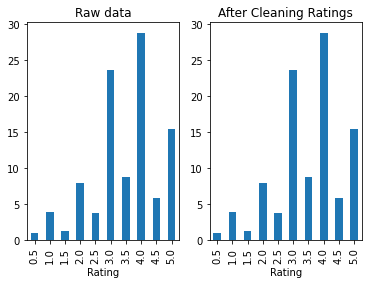

In [164]:
### Removing rows with nan in tile and genre
final.dropna(inplace=True)
final.describe()

### Checking the hisotgrma of Ratings
fig, axes = plt.subplots(nrows=1, ncols=2)
count_rates = final.groupby('Rating').count()
count_rates['perc_total']=round(count_rates['UserID']*100/count_rates['UserID'].sum(),1)
count_rates['perc_total'].plot.bar(title="Raw data",ax=axes[0])

### Removing rows with negative Rating and Ratings more than 5
final=final[(final.Rating<=5) & (final.Rating>=0)]
count_rates = final.groupby('Rating').count()
count_rates['perc_total']=round(count_rates['UserID']*100/count_rates['UserID'].sum(),1)
count_rates['perc_total'].plot.bar(title="After Cleaning Ratings",ax=axes[1])

### Changing the userID, MovieID into INT (currently float64)
final.UserID=final.UserID.astype(int)
final.MovieID=final.MovieID.astype(int)

### Removing duplicate ratings if any
### using DASK to reduce time

In [135]:
print("We have %d users"%final.UserID.nunique())
print("We have %d movies"%final.MovieID.nunique())

## using DASK to use multiple core
from dask import dataframe as dd
# final=final.sample(frac=0.01)
final_d = dd.from_pandas(final, npartitions=2)
ratings_df_d = final_d.groupby(['UserID','MovieID']).aggregate(np.max)
# ratings_df = final.groupby(['UserID','MovieID']).aggregate(np.max)
ratings_df_d.head()
print(len(ratings_df_d))
# print(len(ratings_df))
if (len(ratings_df_d) == final.shape[0]):
# if (len(ratings_df) == final.shape[0]):
  print("there are no such cases where the user has rated the same movie twice.")

We have 100 users
We have 100 movies


,,Rating,Timestamp,Title,Genres,Date
UserID,MovieID,,,,,
4007,2391,5.0,946341544,"Simple Plan, A (1998)",Crime|Drama|Thriller,1999-12-27
4105,2717,4.5,1135591943,Ghostbusters II (1989),Action|Comedy|Fantasy|Horror|Sci-Fi,2005-12-26
4538,3923,3.5,1086592200,Return of the Fly (1959),Horror|Sci-Fi,2004-06-07
7145,32,4.5,1056134831,12 Monkeys (Twelve Monkeys) (1995),Sci-Fi|Thriller,2003-06-20
8010,205,3.0,844937001,Unstrung Heroes (1995),Comedy|Drama,1996-10-10


100
there are no such cases where the user has rated the same movie twice.


## Creating one hot encoding for genres

In [136]:
# finding all availbale genres
final['Genres'] = final['Genres'].str.replace('|',' ')
all_genres=list(set(final.Genres.str.cat(sep=' ').split()))
final[all_genres]=0

# Adding one hot endodings
for genre in all_genres :
  final[genre] = final.apply(lambda row:int(genre in row.Genres), axis = 1)
final.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Date,Thriller,Mystery,Animation,...,Crime,Musical,Western,Romance,Action,Sci-Fi,Children,Documentary,Adventure,Drama
8622895,61783,836,3.0,1046525928,Chain Reaction (1996),Action Adventure Thriller,2003-03-01,1,0,0,...,0,0,0,0,1,0,0,0,1,0
7408626,52909,1957,0.5,1154199427,Chariots of Fire (1981),Drama,2006-07-29,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1237386,9114,3190,1.0,1003127192,Supernova (2000),Adventure Sci-Fi Thriller,2001-10-15,1,0,0,...,0,0,0,0,0,1,0,0,1,0
6512008,46568,4855,4.0,1016831978,Dirty Harry (1971),Action Crime Drama Thriller,2002-03-22,1,0,0,...,1,0,0,0,1,0,0,0,0,1
4737621,33855,2959,5.0,1067202128,Fight Club (1999),Action Crime Drama Thriller,2003-10-26,1,0,0,...,1,0,0,0,1,0,0,0,0,1


## List of top rated movies without considering the number of rates

In [137]:
top_movies_ID=final.groupby('Title')['Rating'].mean().sort_values(ascending=False)
top_movies_ID.head()

Title
Star Wars: Episode VI - Return of the Jedi (1983)    5.0
Fight Club (1999)                                    5.0
Mystery Science Theater 3000: The Movie (1996)       5.0
Harold and Maude (1971)                              5.0
Glengarry Glen Ross (1992)                           5.0
Name: Rating, dtype: float64

## List of top rated movies, considering the count of rates (Removing movies less than 20 rates)

In [138]:
avg_movie_rating = pd.DataFrame(final.groupby('Title')['Rating'].agg(['mean','count']))
min_no_rates=20
avg_movie_rating=avg_movie_rating[avg_movie_rating['count']>min_no_rates].sort_values(by='mean',ascending=False)
avg_movie_rating.head()

,mean,count
Title,,


## finding the movie with maximum consecetive ratings

In [139]:
 from datetime import timedelta
 sc=lambda x: sum(x.sort_values().diff()==timedelta(days = 1))
 rating_diff_days=final.groupby('Title')['Date'].agg(sc)
 rating_diff_days.idxmax()

'12 Monkeys (Twelve Monkeys) (1995)'

## finding top 5 genres

In [140]:
# Top genres bases on ratings
genre_rating=[final[final[genre]==1]['Rating'].mean() for genre in all_genres]
sorted_genres=[x for _,x in sorted(zip(genre_rating,all_genres))]
sorted_genres[:5]


['Western', 'War', 'Musical', 'Thriller', 'Action']

## Item based collaborative filtering using Deep Learning (Keras)
### 1. assigning unique ID and 

In [141]:
from sklearn.model_selection import train_test_split
final.columns
newratedmovies = final[['UserID','MovieID','Rating','Genres','Title']].copy()
newratedmovies.columns



#  creating a mapping dictionary to map old userID into new userID that will be used as NN input
userID_mapper=dict( zip( newratedmovies.UserID,newratedmovies.UserID.astype('category').cat.codes.values ) )

# Assigning a unique value to each user and movie in range 0,no_of_users and 0,no_of_movies and 0, no_of_genres respectively.
newratedmovies.UserID = newratedmovies.UserID.astype('category').cat.codes.values
newratedmovies.MovieID = newratedmovies.MovieID.astype('category').cat.codes.values




# splitting the train test set
train, test = train_test_split(newratedmovies, test_size=0.2)
train.head()

Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Title', 'Genres', 'Date',
       'Thriller', 'Mystery', 'Animation', 'Fantasy', 'Horror', 'Comedy',
       'War', 'Crime', 'Musical', 'Western', 'Romance', 'Action', 'Sci-Fi',
       'Children', 'Documentary', 'Adventure', 'Drama'],
      dtype='object')

Index(['UserID', 'MovieID', 'Rating', 'Genres', 'Title'], dtype='object')

,UserID,MovieID,Rating,Genres,Title
2622089,19,24,4.0,Adventure Children,"Adventures of Pinocchio, The (1996)"
8797136,83,91,4.5,Comedy Romance,Adam's Rib (1949)
2103342,15,52,3.0,Comedy Mystery,"Trouble with Harry, The (1955)"
8053122,74,85,3.5,Comedy,Van Wilder (2002)
5883886,50,15,3.0,Comedy,Ace Ventura: Pet Detective (1994)


In [142]:
n_users, n_movies, n_genres = len(newratedmovies.UserID.unique()), len(newratedmovies.MovieID.unique()), len(newratedmovies.Genres.unique())
print(n_users, n_movies, n_genres )

100 100 68


In [143]:
from keras.layers import Dense, Dropout, Flatten, Embedding, Input, dot, concatenate, merge
import keras
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def create_matrix_factorisation_model_NN(n_latent_factors, opt) :
  movie_input = keras.layers.Input(shape=(1,),name='Item',dtype='int64')
  movie_embedding = keras.layers.Embedding(0,n_movies, n_latent_factors, name='Movie-Embedding')(movie_input)
  movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

  user_input = keras.layers.Input(shape=(1,),name='User',dtype='int64')
  user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
  user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
  
  prod = dot([movie_vec, user_vec],name='DotProduct', axes = 1)

  model = keras.Model([user_input, movie_input], prod)
  model.compile(optimizer = opt , loss = 'mean_squared_error')

  return model


batch_size=128
epochs=30
TESTUSER = 10
n_latent_factors = 10
optimizer = Adam()
model = create_matrix_factorisation_model(n_latent_factors, optimizer)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 10)        1010        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        1010        User[0][0]                       
____________________________________________________________________________________________

## Creating the NN Model and fit to train set

In [144]:
from IPython.display import clear_output
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('bestweights.h5', save_best_only=True)]

History = model.fit([train.UserID,train.MovieID],train.Rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([test.UserID,test.MovieID],test.Rating),
                              verbose = 1, callbacks=callbacks)
# clear_output()

Train on 80 samples, validate on 20 samples
Epoch 1/30
80/80 [==============================] - 1s 11ms/step - loss: 13.1226 - val_loss: 14.9265
Epoch 2/30
80/80 [==============================] - 0s 70us/step - loss: 13.1193 - val_loss: 14.9265
Epoch 3/30
80/80 [==============================] - 0s 75us/step - loss: 13.1160 - val_loss: 14.9265


## Plotting the train and test loss for each epoch

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epochs')

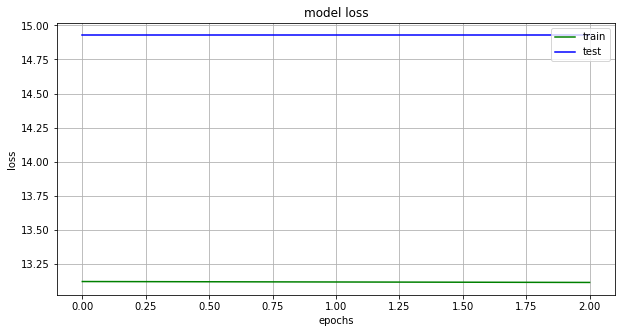

In [145]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

## Minimum RMSE 

In [146]:
import math
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(History.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 1 = 3.8635


## What are the top 5 recommended movies made to one user .  test_userID=61783

In [152]:
# # Use the pre-trained model
model.load_weights('bestweights.h5')

# test use ID 
test_userID=61783
TESTUSER=userID_mapper[test_userID]

# finiding movies not seen by this use
all_movies=list(set(newratedmovies.MovieID))
user_seen_movies=list(newratedmovies[newratedmovies.UserID==TESTUSER].MovieID)
user_not_seen_movies=[m for m in all_movies if m not in user_seen_movies]

# Function to predict the ratings given User ID and Movie ID
def predict_rating(user_id, movie_id):
  return model.predict([np.array([user_id]), np.array([movie_id])])[0][0]

# predicitng the rating for movies NOT SEEN by user
not_seen_predicted_rating=[]
for movieID in user_not_seen_movies:
    not_seen_predicted_rating += [predict_rating(TESTUSER, movieID)]

# Sorting the predicted ratings 
sorted_recommended_movieIDs=[x for _, x in sorted(zip(not_seen_predicted_rating, user_not_seen_movies))]

# recoomeding the top 5 ratings(Titles)
newratedmovies[newratedmovies['MovieID'].isin(sorted_recommended_movieIDs[0:5])].Title

### recommendation

2391345    Sixth Sense, The (1999)
7466469           King Kong (2005)
7198989        Rapture, The (1991)
8957521             Platoon (1986)
8556328        Postman, The (1997)
Name: Title, dtype: object

In [ ]:
recommendations = newratedmovies[newratedmovies['MovieID'].isin(user_ratings['MovieID']) == False][['MovieID']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TESTUSER, x['MovieID']), axis=1)

TypeError: <lambda>() got an unexpected keyword argument 'axis'